# Experiments Notebook

This notebook includes the code to run all the experiments presented in the accompanying paper, and some additional ones that were not included due to space limitations.

For the experiments presented in the paper, the repository also include files with the inference and runtime results.

Running this notebook requires having SPUR, CMSGen and MegaSampler installed. See the `README.md` file in the root of this repository for instructions.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # for tight_layout()

import itertools
import random
import operator

import glob

import os, sys
sys.path.append(os.path.join("../"))

# Configure logging
import logging
logging.basicConfig(
    filename='experiments.log',  
    level=logging.DEBUG, 
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# our library
from src.mcmc_sat import models, mcmc, smt


## Convergence experiments

### DB CACM

#### Posterior inference

In [2]:
## Utility functions to save and load traces computed by the experiments

def save_experiment_traces_list(traces_problem, problem: str, backends: list[str] = ['spur', 'cmsgen', 'megasampler']):
    for (samples, traces_backends) in traces_problem:
        for (backend, traces) in zip(backends, traces_backends):
            i = 0
            for trace in traces:            
                i += 1
                az.to_netcdf(trace, f'traces/trace_{problem}_{samples}_{backend}_{i}.nc')

def load_experiment_traces_list(problem: str, 
                                num_samples: list[int] = np.concatenate([[100], np.arange(5000, 20001, step=5000)]), 
                                backends: list[str] = ['spur', 'cmsgen', 'megasampler']):
    return [
        (samples, [ [ az.from_netcdf(f'traces/trace_{problem}_{samples}_{backend}_{rep+1}.nc') for rep in range(3)] for backend in backends ]) 
        for samples in num_samples]

In [3]:
def generate_traces_db_cacm_experiment():
    num_samples = np.concatenate([[100], np.arange(5000, 20001, step=5000)])
    TIMEOUT = 60*10 # seconds (10min)
    
    (g, num_bits, num_vars) = models.get_db_cacm_sat()
    (s, num_vars) = models.get_db_cacm_smt()
    backends = ['spur', 'cmsgen', 'megasampler']
    traces_db_cacm = [ 
            (samples, 
        [[mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                           z3_problem=g,
                                           num_bits=num_bits,
                                           num_vars=num_vars,
                                           timeout_sampler=TIMEOUT,
                                           num_samples=samples)
        if backend in ['spur','cmsgen']
        else mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=s,
                timeout_sampler=TIMEOUT,
                reweight_samples=True,
                num_samples=samples)
        for rep in range(3)] for backend in backends ]) # we run each experiment 3 times
        for samples in num_samples]
    # save_experiment_traces_list(traces_db_cacm, 'db_cacm') ## save traces if needed
    return traces_db_cacm

def load_db_cacm_experiment_traces():
    return load_experiment_traces_list(problem='db_cacm')

In [4]:
## Toggle this flag to regenerate the traces for this experiment
## In the current setting, it uses the traces used for the accompaying paper
load_traces = True
traces_db_cacm = load_db_cacm_experiment_traces() if load_traces else generate_traces_db_cacm_experiment()

#### Convergence analysis

In [5]:
## Analytical solution to db_cacm

### list all ages with required median and average age
avg_sat = [ (x0,x1,30,x3,x4) 
            for x0 in range(31) 
            for x1 in range(31) 
            for x3 in range(30,126) 
            for x4 in range(30,126) 
            if x0+x1+30+x3+x4 == 38*5 and
               x0 <= x1 <= 30 <= x3 <= x4]

### list all genders with exactly 3 males
g_sat = [ (g0,g1,g2,g3,g4) 
          for g0 in range(2) 
          for g1 in range(2) 
          for g2 in range(2) 
          for g3 in range(2) 
          for g4 in range(2) 
          if g0+g1+g2+g3+g4 == 3]

### keep only entries with the required average for males
sat_models = [((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4))
              for (x0,x1,x2,x3,x4) in avg_sat 
              for (g0,g1,g2,g3,g4) in g_sat 
              if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
]

### prior on each variable type
p_x01 = lambda x: 1/31
p_x2 = lambda x: 1
p_x34 = lambda x: 1/96
p_g = lambda x: 1/2

### compute unnormalized posterior probabilities
### all variables are independent therefore it is the product
unnormalized_probs = np.array([p_x01(x0) * p_x01(x1) * p_x2(x2) * p_x34(x3) * p_x34(x4) * p_g(g0) * p_g(g1) * p_g(g2) * p_g(g3) * p_g(g4)
                               for (x0,x1,x2,x3,x4) in avg_sat 
                               for (g0,g1,g2,g3,g4) in g_sat 
                               if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
])

### compute total probability mass (normalizing factor)
total_prob = sum(unnormalized_probs)

### normalized probabilities
normalized_probs = unnormalized_probs/total_prob

### We put everything in a dataframe to easily make queries
d = {
    'x0': [], 'x1': [], 'x2': [], 'x3': [], 'x4': [], 
    'g0': [], 'g1': [], 'g2': [], 'g3': [], 'g4': [], 
    'p' : []
}

for (((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4)), p) in zip(sat_models,normalized_probs):
    d['x0'].append(x0)
    d['x1'].append(x1)
    d['x2'].append(x2)
    d['x3'].append(x3)
    d['x4'].append(x4)
    d['g0'].append(g0)
    d['g1'].append(g1)
    d['g2'].append(g2)
    d['g3'].append(g3)
    d['g4'].append(g4)
    d['p'].append(p)

df = pd.DataFrame(d)

### function to query exact solution probability for each variable and outcome
p_var = lambda x,i: df[df[x] == i].p.sum()

In [6]:
## We generate a dataframe with the convergence analysis results

backends = ['spur', 'cmsgen', 'megasampler']
def p_est(trace, var_name, outcome):
    return np.mean(trace[var_name] == outcome)
data_db_cacm = {
    'samples':  [],
    'backend':  [],
    'var_name': [],
    'err_mean_mean': [],
    'err_mean_var': []
}
for (samples, traces) in traces_db_cacm:
    for (backend, trace_reps) in zip(backends, traces):
        for x in ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']:
            ## ranges are variable specific for DB cacm
            ran = range(30,31)
            if x in ['x0','x1']:
                ran = range(31)
            elif x in ['x3','x4']:
                ran = range(30,126)
            elif x in ['x5','x6','x7','x8','x9']:
                ran = range(2)

            outcomes = ran                

            x_conv = x if x in ['x0','x1','x2','x3','x4'] else 'g'+str((int(x[1])-5))

            err_outcome_means = [np.mean([np.abs(p_est(trace.posterior.sel(chain=0),x, o).item() - p_var(x_conv,o)) for o in outcomes]) for trace in trace_reps]
            data_db_cacm['samples'].append(samples)
            data_db_cacm['backend'].append(backend)
            data_db_cacm['var_name'].append(x)
            data_db_cacm['err_mean_mean'].append(np.mean(err_outcome_means))
            data_db_cacm['err_mean_var'].append(np.var(err_outcome_means))
df_db_cacm = pd.DataFrame(data_db_cacm)
# df_db_cacm.to_csv('results_convergence_db_cacm.csv', index=False) ## save it if needed

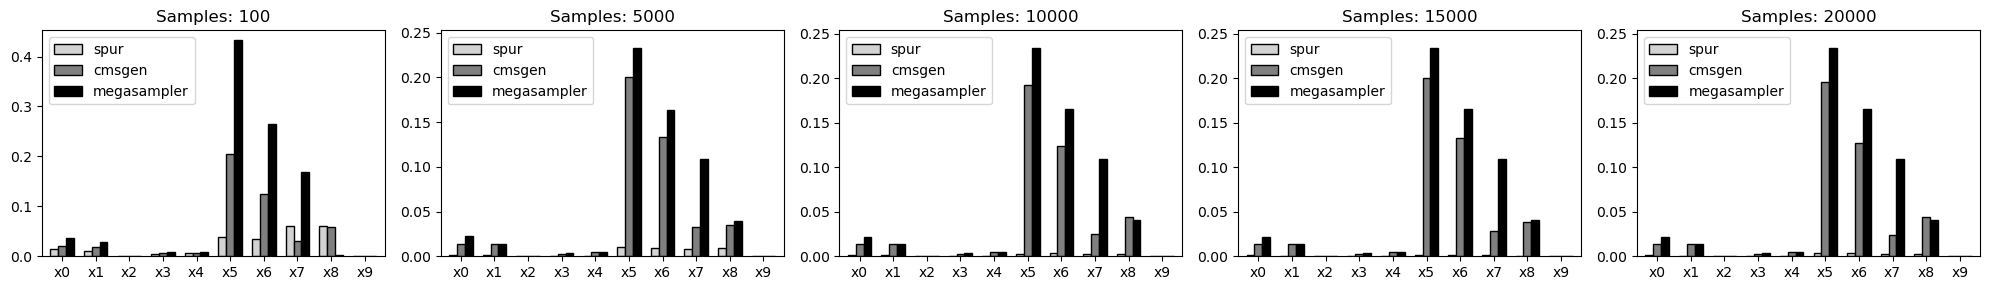

In [7]:
## Histogram plots comparing convergence for increasing number of samples
num_samples = df_db_cacm.samples.unique()
fig, axs = plt.subplots(1,len(num_samples),figsize=(20,3))
for (s,a) in zip(num_samples, axs):
    data = {b: [] for b in backends}
    for b in backends:
        data[b] = df_db_cacm[(df_db_cacm.samples == s) & (df_db_cacm.backend == b)].err_mean_mean.values
    df_temp = pd.DataFrame(data)
    ax = df_temp.plot.bar(ax=a, color=['#D3D3D3', '#808080', '#000000'], edgecolor='black', width=0.7)
    variables = df_db_cacm.var_name.unique()
    ax.set_xticks(range(len(variables)), variables,rotation=0)
    ax.set_ylim((0,np.max(df_temp.values+0.02)))
    ax.legend(['spur','cmsgen','megasampler'])
    ax.set_title(f'Samples: {s}');
# plt.savefig('convergence_db_cacm_hist.pdf'); ## save it if needed

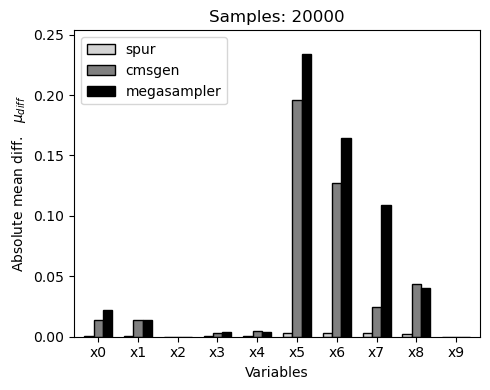

In [8]:
## Histogram plot comparing convergence for the maximum number of samples, i.e., 20000 (plot for the paper)

fig, a = plt.subplots(1,1,figsize=(5,4))
for b in backends:
    data[b] = df_db_cacm[(df_db_cacm.samples == 20000) & (df_db_cacm.backend == b)].err_mean_mean.values
df_temp = pd.DataFrame(data)
ax = df_temp.plot.bar(ax=a, color=['#D3D3D3', '#808080', '#000000'], edgecolor='black', width=0.7)
variables = df_db_cacm.var_name.unique()
ax.set_xticks(range(len(variables)), variables,rotation=0)
ax.set_ylim((0,np.max(df_temp.values+0.02)))
ax.legend(['spur','cmsgen','megasampler'])
ax.set_xlabel('Variables')
ax.set_ylabel('Absolute mean diff.   $\\mu_{diff}$')
ax.set_title(f'Samples: {s}')
ax.legend(loc='upper left');
# plt.savefig('convergence_db_cacm_hist_20000.pdf') ## save it if needed

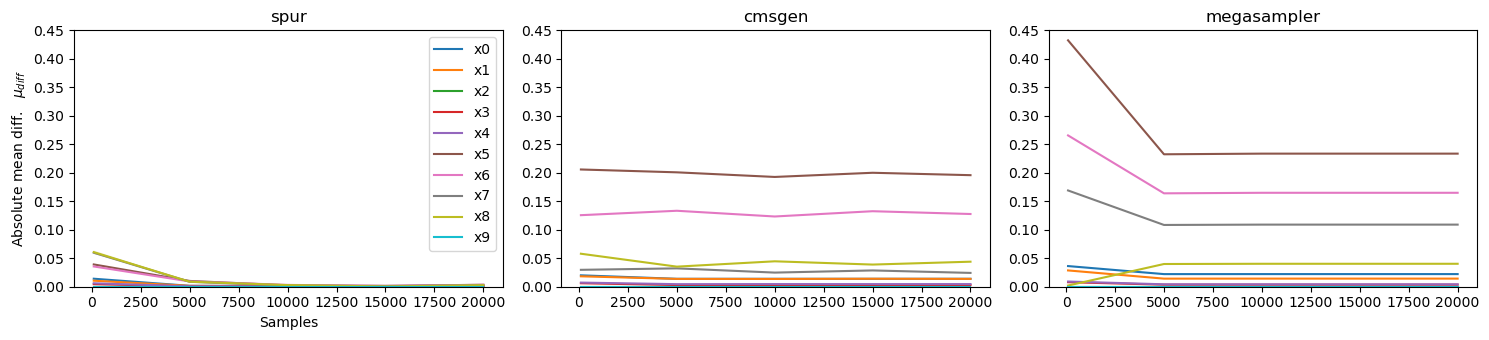

In [9]:
## Line plots comparing convergence for increasing number of samples (plot for the paper)

fig, axs = plt.subplots(1,len(backends),figsize=(15,3.5))

for (ax, b) in zip(axs, backends):
    ys = [(vn, 
           df_db_cacm[(df_db_cacm.var_name == vn) & (df_db_cacm.backend == b)].err_mean_mean.values,
           df_db_cacm[(df_db_cacm.var_name == vn) & (df_db_cacm.backend == b)].err_mean_var.values) 
              for vn in ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']]
    for (vn, y, y_var) in ys:
        ax.plot(num_samples, y, label=vn)
        ax.fill_between(num_samples, y-y_var, y+y_var, alpha=0.2)
    ax.set_ylim((0,0.45))
    ax.set_title(f'{b}')
    if b == 'spur':
        ax.set_xlabel('Samples')
        ax.set_ylabel('Absolute mean diff.   $\\mu_{diff}$')
        ax.legend();
# plt.savefig('convergence_db_cacm_plot.pdf'); ## save it if needed

### NZ Stats

#### Posterior inference

In [10]:
def generate_traces_nz_stats_experiment():
    num_samples = np.concatenate([[100], np.arange(5000, 20001, step=5000)])
    TIMEOUT = 60*10 # seconds (10min)
    
    (g, num_bits, num_vars) = models.get_nz_stats_sat(
        path_to_dataset='sat/spur/nz_db/south_head.csv'
    )
    (s, num_vars) = models.get_nz_stats_smt(
        path_to_dataset='sat/spur/nz_db/south_head.csv'
    )
    backends = ['spur', 'cmsgen', 'megasampler']
    traces_nz_stats = [
        (samples,
        [[mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                           z3_problem=g,
                                           num_bits=num_bits,
                                           num_vars=num_vars,
                                           timeout_sampler=TIMEOUT,
                                           num_samples=samples)
        if backend in ['spur','cmsgen']
        else mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=s,
                timeout_sampler=TIMEOUT,
                reweight_samples=True,
                num_samples=samples)
        for rep in range(3)] for backend in backends])
        for samples in num_samples]
    # save_experiment_traces_list(traces_nz_stats, 'nz_stats') ## save traces if needed
    return traces_nz_stats

def load_nz_stats_experiment_traces():
    return load_experiment_traces_list('nz_stats')

In [11]:
## Toggle this flag to regenerate the traces for this experiment
## In the current setting, it uses the traces used for the accompaying paper
load_traces = True
traces_nz_stats = load_nz_stats_experiment_traces() if load_traces else generate_traces_nz_stats_experiment()

#### Convergence analysis

In [12]:
## Analytical solution

path_to_dataset = 'sat/spur/nz_db/south_head.csv'
south_head = pd.read_csv(path_to_dataset)
numpy_data = south_head.to_numpy()[:, 1:]

def get_values(x):
    upper_bound = x+2
    lower_bound = x-2 if x > 0 else 0
    return list(range(lower_bound,upper_bound+1))

p = lambda x: 1/5 if x > 0 else 1/3

unnorm_probs = [ [(i,j,p(numpy_data[0,k])*p(numpy_data[1,k])) 
   for i in get_values(numpy_data[0,k]) 
   for j in get_values(numpy_data[1,k])
   if (numpy_data[2,k] - 2) <= (i+j) <= (numpy_data[2,k] + 2)]
  for k in range(19)]

norm_probs = [[(x,y,prob1/sum([prob2 for (_,_,prob2) in i])) for (x,y,prob1) in i] for i in unnorm_probs]

p_var_nz_stats = lambda var_num, outcome: sum([t[2] for t in norm_probs[var_num%19] if t[int(var_num > 18)] == outcome])

p_var = lambda x,o: p_var_nz_stats(x,o)

In [13]:
## We generate a dataframe with the convergence analysis results

backends = ['spur', 'cmsgen', 'megasampler']
def p_est(trace, var_name, outcome):
    return np.mean(trace[var_name] == outcome)

data_nz_stats = {
    'samples':  [],
    'backend':  [],
    'var_name': [],
    'err_mean_mean': [],
    'err_mean_var': []
}
for (samples, traces) in traces_nz_stats:
    for (backend, trace_reps) in zip(backends, traces):
        for x in [f'x{i}' for i in range(19*2)]:
            ## ranges are variable specific for NZ DB
            var_int_id = int(x[1:])
            ran = get_values(numpy_data[int(var_int_id > 18),(var_int_id%19)])
            outcomes = ran

            err_outcome_means = [np.mean([np.abs(p_est(trace.posterior.sel(chain=0), x, o).item() - p_var(var_int_id,o)) for o in outcomes]) for trace in trace_reps]
            data_nz_stats['samples'].append(samples)
            data_nz_stats['backend'].append(backend)
            data_nz_stats['var_name'].append(x)
            data_nz_stats['err_mean_mean'].append(np.mean(err_outcome_means))
            data_nz_stats['err_mean_var'].append(np.var(err_outcome_means))
df_nz_stats = pd.DataFrame(data_nz_stats)
# df_nz_stats.to_csv('results_convergence_nz_stats.csv') ## save it if needed

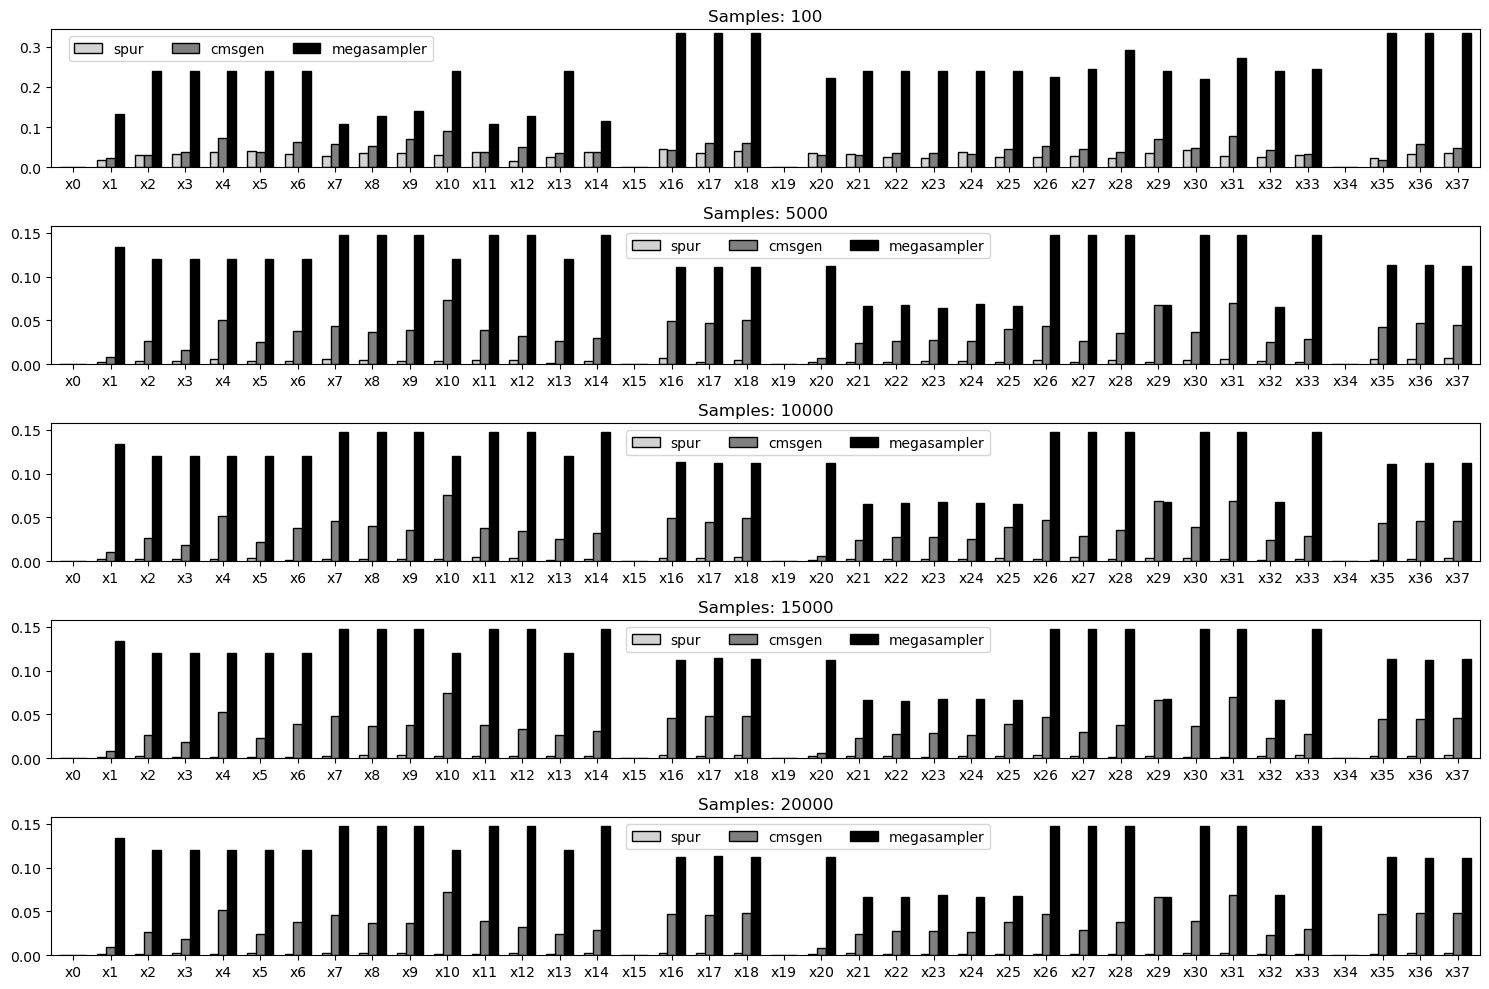

In [14]:
## Histogram plots comparing convergence for increasing number of samples
num_samples = df_db_cacm.samples.unique()
fig, axs = plt.subplots(len(num_samples),1,figsize=(15,10))
for (s,a) in zip(num_samples, axs):
    data = {b: [] for b in backends}
    for b in backends:
        data[b] = df_nz_stats[(df_nz_stats.samples == s) & (df_nz_stats.backend == b)].err_mean_mean.values
    df_temp = pd.DataFrame(data)
    ax = df_temp.plot.bar(ax=a, color=['#D3D3D3', '#808080', '#000000'], edgecolor='black', width=0.7)
    variables = df_nz_stats.var_name.unique()
    ax.set_xticks(range(len(variables)), variables,rotation=0)
    ax.set_ylim((0,np.max(df_temp.values+0.01)))
    ax.legend(['spur','cmsgen','megasampler'], ncols=3, loc='upper center', 
              bbox_to_anchor=(0.53 if not s == 100 else 0.14, 1))
    ax.set_title(f'Samples: {s}');
    # plt.savefig('convergence_nz_stats_hist.pdf'); save it if needed

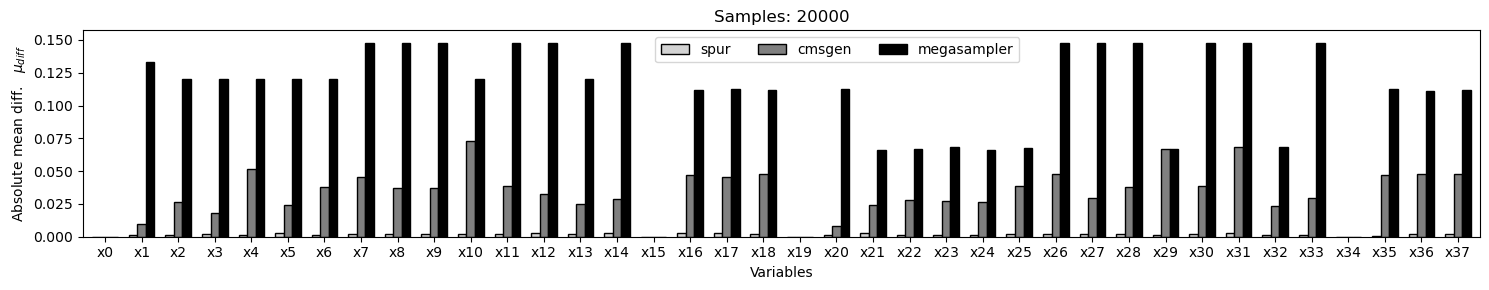

In [15]:
## Histogram plot comparing convergence for the maximum number of samples, i.e., 20000 (plot for the paper)
fig, a = plt.subplots(1,1,figsize=(15,3))
s = 20000
data = {b: [] for b in backends}
for b in backends:
    data[b] = df_nz_stats[(df_nz_stats.samples == s) & (df_nz_stats.backend == b)].err_mean_mean.values
df_temp = pd.DataFrame(data)
ax = df_temp.plot.bar(ax=a, color=['#D3D3D3', '#808080', '#000000'], edgecolor='black', width=0.7)
variables = df_nz_stats.var_name.unique()
ax.set_xticks(range(len(variables)), variables,rotation=0)
ax.set_ylim((0,np.max(df_temp.values+0.01)))
ax.legend(['spur','cmsgen','megasampler'], ncols=3, loc='upper center', bbox_to_anchor=(0.54, 1))
ax.set_xlabel('Variables')
ax.set_ylabel('Absolute mean diff.   $\\mu_{diff}$')
ax.set_title(f'Samples: {s}');
# plt.savefig('convergence_nz_stats_hist_20000.pdf'); ## save it if needed

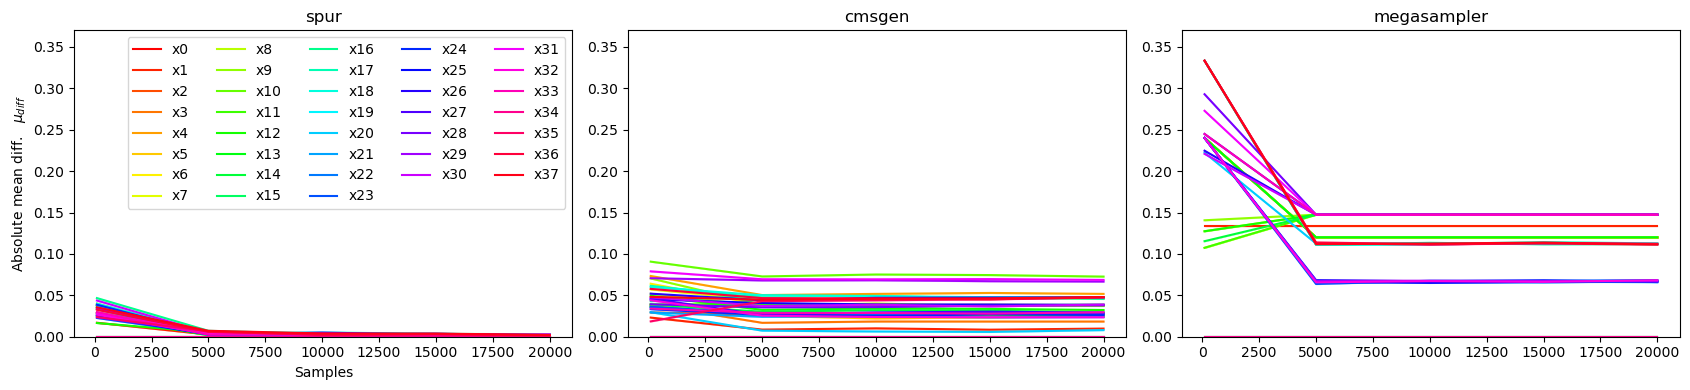

In [16]:
## Line plots comparing convergence for increasing number of samples (plot for the paper)
fig, axs = plt.subplots(1,len(backends),figsize=(17,4))
for (ax, b) in zip(axs, backends):
    ys = [(vn, 
           df_nz_stats[(df_nz_stats.var_name == vn) & (df_nz_stats.backend == b)].err_mean_mean.values,
           df_nz_stats[(df_nz_stats.var_name == vn) & (df_nz_stats.backend == b)].err_mean_var.values) 
              for vn in [f'x{i}' for i in range(19*2)]]
    for ((vn, y, y_var), c) in zip(ys,plt.cm.hsv(np.linspace(0, 1, len(ys)))):
        ax.plot(num_samples, y, color=c, label=vn)
        ax.fill_between(num_samples, y-y_var, y+y_var, color=c, alpha=0.2)
    ax.set_ylim((0,0.37))
    ax.set_title(f'{b}');
    if b == 'spur':
        ax.set_xlabel('Samples')
        ax.set_ylabel('Absolute mean diff.   $\\mu_{diff}$')
        ax.legend(ncols=5)
# plt.savefig('convergence_nz_stats_plot.pdf') save it if needed

### DB CACM and NZ Stats convergence summary

In [17]:
def print_max_abs_diff_mean(backend: str, min_num_samples: int, df_db_cacm, df_nz_stats):
    db_cacm_max_abs_diff_mean  = df_db_cacm[(df_db_cacm.backend == backend) & (df_db_cacm.samples > min_num_samples)].err_mean_mean.max()
    nz_stats_max_abs_diff_mean = df_nz_stats[(df_nz_stats.backend == backend) & (df_nz_stats.samples > min_num_samples)].err_mean_mean.max()
    print(f'For DB CACM, {backend} shows an maximum absolute difference mean error of {db_cacm_max_abs_diff_mean} for more than {min_num_samples} samples')
    print(f'For NZ Stats, {backend} shows an maximum absolute difference mean error of {nz_stats_max_abs_diff_mean} for more than {min_num_samples} samples')

In [18]:
for bckd in backends:
    min_s = 15000
    print_max_abs_diff_mean(backend=bckd, min_num_samples=min_s, df_db_cacm=df_db_cacm, df_nz_stats=df_nz_stats)

For DB CACM, spur shows an maximum absolute difference mean error of 0.003422870662457935 for more than 15000 samples
For NZ Stats, spur shows an maximum absolute difference mean error of 0.0031555555555555625 for more than 15000 samples
For DB CACM, cmsgen shows an maximum absolute difference mean error of 0.1957895373291246 for more than 15000 samples
For NZ Stats, cmsgen shows an maximum absolute difference mean error of 0.07262 for more than 15000 samples
For DB CACM, megasampler shows an maximum absolute difference mean error of 0.2335877627988532 for more than 15000 samples
For NZ Stats, megasampler shows an maximum absolute difference mean error of 0.1473684210526316 for more than 15000 samples


## Scalability experiments

In [19]:
## Utility functions to load performance experiment results from disk

def get_info_from_runtime_filename(filename: str):
    """
    Utility function to extract experiment information from filename format in roads and books runtime results files.
    """
    parsed_filename = filename.split('_')
    problem    = parsed_filename[1].split('/')[1]
    num_con    = int(parsed_filename[4])
    red_fac    = int(parsed_filename[6])
    num_bits   = int(parsed_filename[8])
    max_int_bv = int(parsed_filename[11].split('.')[0])
    return (problem, num_con, red_fac, num_bits, max_int_bv)

def get_info_from_num_con_and_red_fac(problem:str, num_con: int, rf: int):
    """
    Utility function to obtain experiment information from problem name (roads or books), number of constraints and reductino factor.
    It requires that the results file for the target experiment has been computed.
    """
    con_or_case = lambda x: 'con' if x=='roads' else 'case'
    files = glob.glob(f'performance_results/{problem}_results_{con_or_case(problem)}_{num_con}_rf_{rf}_*.csv')
    if len(files) > 0:
        file  = files[0]
        return get_info_from_runtime_filename(file)
    else:
        raise RuntimeError(f'File not found for {problem} problem with {num_con} constraints and reduction factor {rf}')
    
def __get_num_vars(problem: str, num_con: int):
    """
    Utility function to obtain the number of variables in a problem
    """
    if problem == 'roads':
        if num_con == 2:
            return 13
        if num_con == 3:
            return 18
        if num_con == 4:
            return 22
        if num_con == 5:
            return 25
        if num_con == 6:
            return 27
        if num_con == 7:
            return 28
    else:
        return 72

### Roads

#### Posterior inference

In [20]:
## Function to run an instance of the roads experiment for a given number of connections (num_con) and reduction factor (reduction_factor)

def execute_runtime_roads_experiment(num_con: int, reduction_factor: int):
    ## experiment data from Hazelton's paper
    y = np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])
    
    ## experiment parameters
    num_samples = [ 100,  500,  1000, 3000, 7000]
    TIMEOUT = 60*10 # seconds (10min)   
    
    
    ## Automatically calculate necessary bits for SAT backends
    num_bits = int(np.log2((y[:num_con]/reduction_factor).max()))+1;
    max_int_bits = max([int(np.log2((total/summands)+1))+1 
                        for (summands,total) in zip(models.__gen_conf_matrix(np.array([1,2,3,4,5,6,7][:num_con])).sum(axis=1), (y[:num_con]/reduction_factor))])
    max_int_bv = 2**max_int_bits-1
     
    ## Get models
    (g, num_bits, num_vars) = models.get_roads_sat(num_bits = num_bits,
                                                   max_int_bv = max_int_bv,
                                                   num_con=num_con,
                                                   y_reduction_factor=reduction_factor)
    (s, num_vars) = models.get_roads_smt(max_int = max_int_bv, 
                                         num_con=num_con,
                                         y_reduction_factor=reduction_factor)
    
    # backends
    backends = ['spur', 'cmsgen', 'megasampler']
    
    # logger
    logger = logging.getLogger(f"Roads runtime | con {num_con} | bits {num_bits} | max_int {max_int_bv}")
    
    # timeouts
    timeout = {
        'spur': False,
        'cmsgen': False,
        'megasampler': False
    }    
    
    ## Function to run the experiment for a given number of samples and backend
    def executing_roads_with_backend(samples, backend):
        logger.info(f'Running roads with {backend} and generating {samples} samples')
    
        if timeout[backend]:
            return (600, 0, None)
    
        # catch TIMEOUT exception
        try:
            (time_sample_gen, time_mcmc, trace) = \
                mcmc.sample_mh_trace_from_z3_model(
                    backend=backend,
                    z3_problem=g,
                    num_bits=num_bits,
                    num_vars=num_vars,
                    timeout_sampler=TIMEOUT,
                    num_samples=samples,
                    time_execution=True) \
            if backend in ['spur','cmsgen'] \
            else mcmc.sample_mh_trace_from_z3_model(
                    backend=backend,
                    z3_problem=s,
                    reweight_samples=True,
                    timeout_sampler=TIMEOUT,
                    num_samples=samples,
                    time_execution=True)
        except Exception as exception:
            logger.error(exception.__class__.__name__)
            (time_sample_gen, time_mcmc, trace) = (600, 0, None)
        
        timeout[backend] = (time_sample_gen + time_mcmc) >= 600
    
        logger.info(f'Execution finished in {time_sample_gen + time_mcmc} seconds')
    
        return (time_sample_gen, time_mcmc, trace)        
    
    ## Run experiments for all number of samples and backends
    traces_roads = [
        (samples,
        [[executing_roads_with_backend(samples, backend)
        for rep in range(3)] for backend in backends])
        for samples in num_samples]
    
    ## Generate dataframe with runtime information
    data_roads = {
        'samples':  [],
        'backend':  [],
        'num_executions': [],
        'sampling_time_mean': [],
        'sampling_time_std': [],
        'metropolis_time_mean': [],
        'metropolis_time_std': [],
        'total_time_mean': [],
        'total_time_std': []
    }
    for (num_samples, results_per_backend) in traces_roads:
        for (backend, results) in zip(backends,results_per_backend):
            sampling_times = np.array([sampling_time for (sampling_time, _, _) in results])
            metropolis_times = np.array([metropolist_time for (_, metropolist_time, _) in results])
            total_times = sampling_times + metropolis_times
            data_roads['samples'].append(num_samples)
            data_roads['backend'].append(backend)
            data_roads['num_executions'].append(sampling_times.size)
            data_roads['sampling_time_mean'].append(sampling_times.mean())
            data_roads['sampling_time_std'].append(sampling_times.std())
            data_roads['metropolis_time_mean'].append(metropolis_times.mean())
            data_roads['metropolis_time_std'].append(metropolis_times.std())
            data_roads['total_time_mean'].append(total_times.mean())
            data_roads['total_time_std'].append(total_times.std())
    df_roads = pd.DataFrame(data_roads)
    df_roads.to_csv(f'performance_results/roads_results_con_{num_con}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')

    return df_roads

For runtime experiments, the posterior inference function above is only necessary to produce and store a dataframe with the running times of the experiments.

We have included the results from our experiments, so the flag below is only needed to re-run the experiments. Otherwise, the code generating plots and comparisons will read the files directly from disk.

**Warning**: Setting the flag below to `True` will result in a very long execution time.

In [21]:
run_performance_roads_experiments = False

if run_performance_roads_experiments:
    conns = np.arange(2,8)
    reduction_factors = np.arange(1,5)    
    for (c,rf) in [(c,rf) for c in conns for rf in reduction_factors]:
        execute_runtime_roads_experiment(num_con=c, reduction_factor=rf)

#### Performance analysis

In [22]:
## Example loading results for specific experiment
num_con = 3
reduction_factor = 4
num_bits = 9
max_int_bv = 127
df_roads = pd.read_csv(f'performance_results/roads_results_con_{num_con}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')

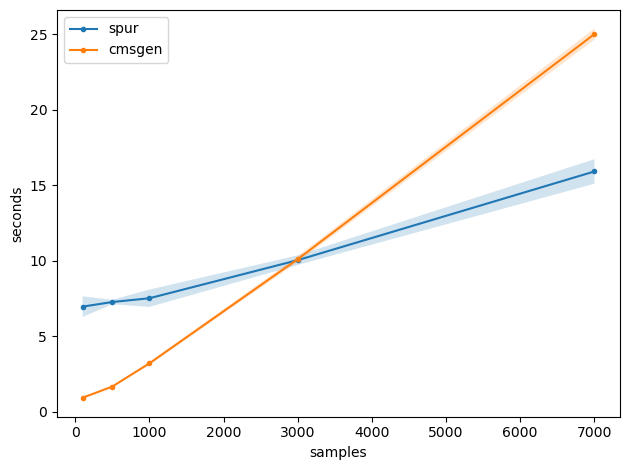

In [23]:
# Line plot for the experiment above
fig, ax = plt.subplots(1)
x = df_roads.samples.unique()
for backend in backends:
    if backend not in ['megasampler']:
        means = df_roads[df_roads.backend == backend].total_time_mean
        stds  = df_roads[df_roads.backend == backend].total_time_std
        ax.plot(x, means, label=backend, marker='.')    
        ax.fill_between(x, means - stds, means + stds, alpha=0.2)
ax.set_ylabel('seconds')
ax.set_xlabel('samples')
plt.legend()
plt.show();

(0.0, 610.0)

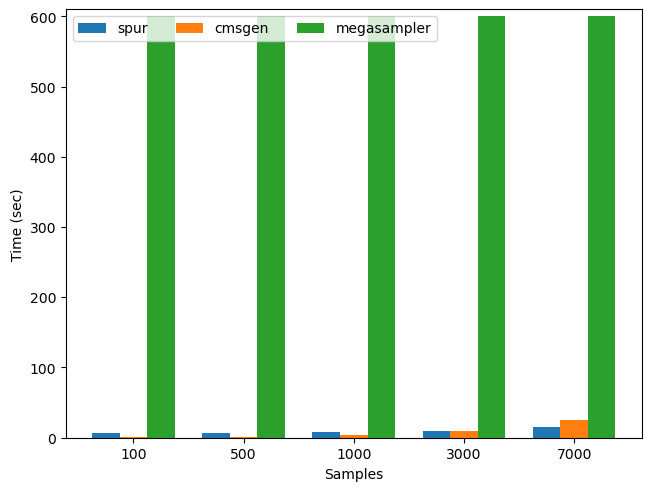

In [24]:
# Histogram plot for the experiment above
num_samples_bars = df_roads.samples.unique()
means = {i: df_roads[df_roads.backend == i].total_time_mean for i in df_roads.backend.unique()}

x = np.arange(len(num_samples_bars))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Time (sec)')
ax.set_xlabel('Samples')
ax.set_xticks(x + width, num_samples_bars)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 610)

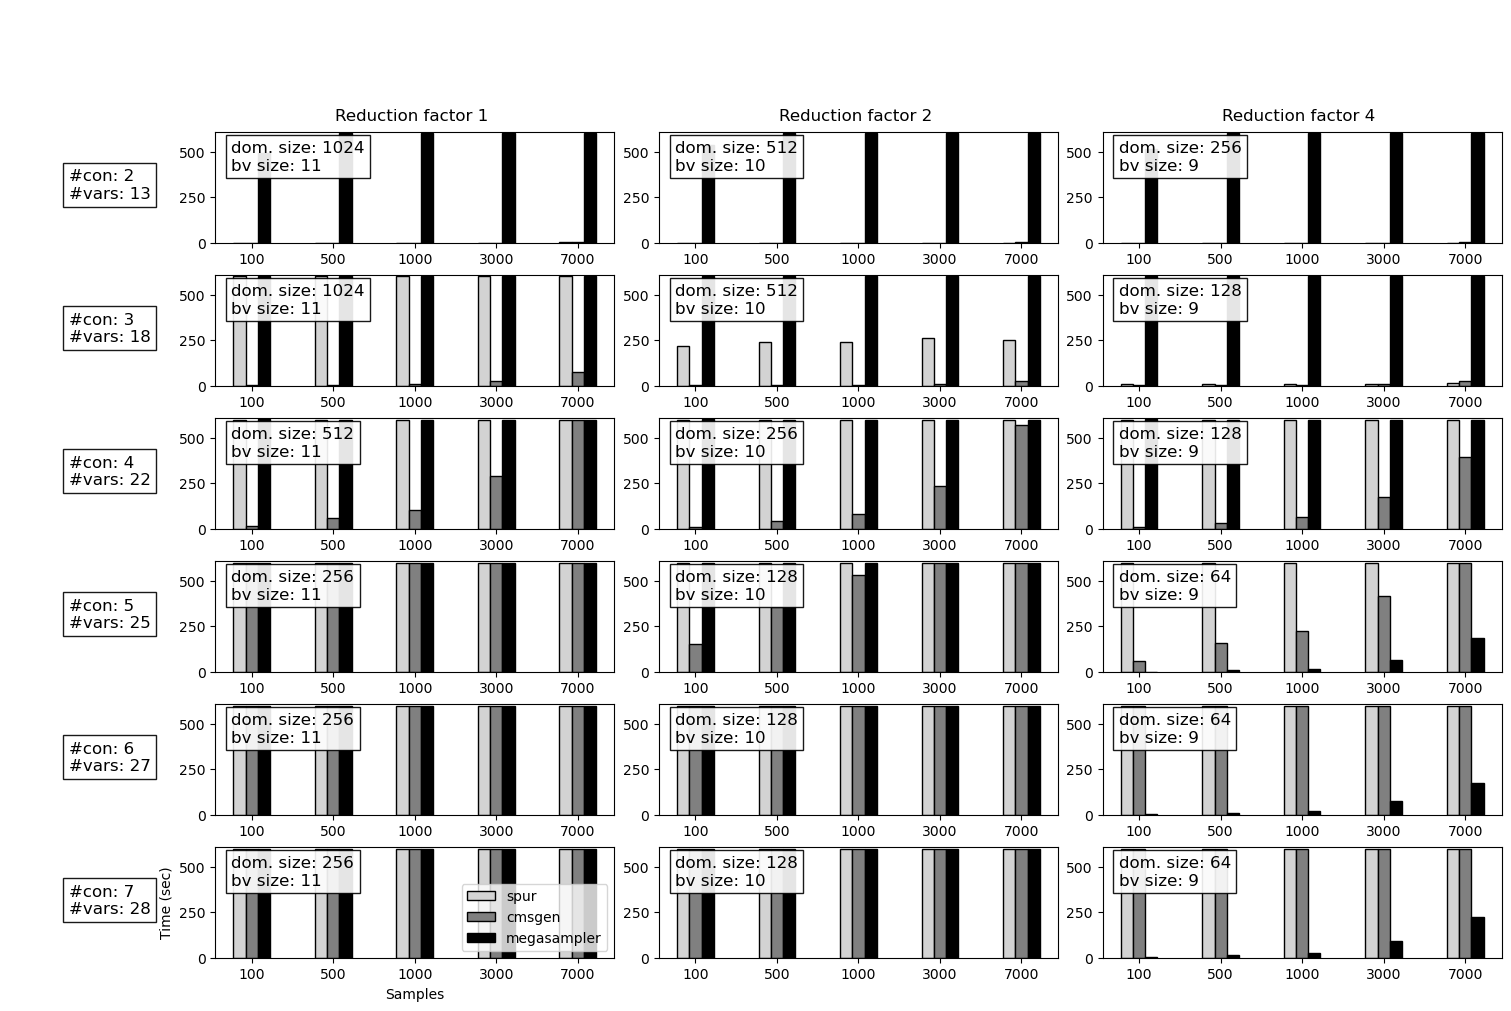

In [25]:
# Histogram plot for all experiments in the accompanying paper
num_cons = [2,3,4,5,6,7]
rfs = [1,2,4]

fig, axs = plt.subplots(len(num_cons)+1,len(rfs)+1, figsize=(15,10), 
                        layout='constrained', width_ratios=np.concatenate([[1], np.repeat(4,len(rfs))]))

axs[0,0].set_axis_off()

for (c,i) in zip(num_cons, range(len(num_cons))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='roads', num_con=c, 
                                                                        # the reduction factor is irrelevant
                                                                        rf=1)
    num_vars = __get_num_vars(problem='roads', num_con=c)
    axs[i+1,0].text(0.59,0.4,f'#con: {c}\n#vars: {num_vars}',
                    bbox=dict(facecolor='white', alpha=0.9),
                    fontsize=12)
    axs[i+1,0].axis('off')

for (r,j) in zip(rfs, range(len(rfs))):
    axs[0,j+1].text(0.3,0,f'Reduction factor {r}', fontsize=12)
    axs[0,j+1].axis('off')

for (c,i) in zip(num_cons, range(len(num_cons))):
    for (r,j) in zip(rfs, range(len(rfs))):

        files = glob.glob(f'performance_results/roads_results_con_{c}_rf_{r}_*.csv')
        if len(files) > 0:
            file  = files[0]
            df = pd.read_csv(file, index_col=False)
            x = df.samples.unique()
            ax = axs[i+1,j+1]

            num_samples_bars = df.samples.unique()
            means = {i: df[df.backend == i].total_time_mean for i in df.backend.unique()}

            x = np.arange(len(num_samples_bars))  # the label locations
            width = 0.15  # the width of the bars
            multiplier = 0

            colors = {'spur': '#D3D3D3', 'cmsgen': '#808080', 'megasampler': '#000000'}

            for attribute, measurement in means.items():
                offset = width * multiplier
                rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute], edgecolor='black')
                multiplier += 1

            ax.set_xticks(x + width, num_samples_bars)
            ax.set_ylim(0, 610)
            
            if i == len(num_cons)-1 and j == 0:
                ax.set_ylabel('Time (sec)')
                ax.set_xlabel('Samples')
                ax.legend(loc='lower right', ncols=1)

            (_, _, _, num_bits, max_int_bv) = get_info_from_runtime_filename(file)
            ax.text(-.1, 400, f'dom. size: {max_int_bv+1}\nbv size: {num_bits}', 
                    bbox=dict(facecolor='white', alpha=0.9), fontsize=12)
        else:
            axs[i+1,j+1].set_axis_off()
# plt.savefig('roads_performance_results.pdf') ## save it if needed
plt.show();

### Books

#### Posterior inference

In [26]:
## Function to run an instance of the books experiment for a given number of 2-way interactions (case_index) and reduction factor (reduction_factor). For 2-way intractions, case_index 0 includes (country, age), 2 includes (country, age) and (age, booktype), and 3 includes (country, age), (age, booktype) and (booktype, country); i.e., all 2-way interactions.

def execute_runtime_books_experiment(case_index: int, reduction_factor: int):
    ## experiment data from Hazelton's paper
    y_books = np.array([3, 12, 1, 21, 86, 16, 2, 24, 5, 184, 822, 163, # (country, age)
                        40, 102, 13, 58, 253, 38, 18, 104, 40, 19, 147, 25, 52, 220, 35, # (age, booktype)
                        1, 3, 6, 8, 36, 5, 1, 14, 2, 1, 10, 13, 3, 43, 4] # (booktype, country)
                    )
    # experiment parameters
    num_samples = [ 100,  500,  1000, 3000, 7000]
    TIMEOUT = 60*10 # seconds (10min)
    
    # number of constraints to include, see comment at the top of the cell
    cases = [12, 27, 42]
    
    # parameters 
    bound = cases[case_index]
    reduction_factor = reduction_factor
    
    ## Automatically calculated necessary bits for SAT backends
    num_bits = int(np.log2((y_books[:bound]/reduction_factor).max()))+1;
    max_int_bits = max([int(np.log2((total/summands)+1))+1 
                        for (summands,total) in zip(models.A_BOOKS[:bound,:].sum(axis=1), (y_books[:bound]/reduction_factor))])
    max_int_bv = 2**max_int_bits-1
    
    
    # Get models
    (g, num_bits, num_vars) = models.get_books_sat(bound=bound, y_reduction_factor=reduction_factor, num_bits=num_bits, max_int_bv=max_int_bv)
    (s, num_vars) = models.get_books_smt(bound=bound, y_reduction_factor=reduction_factor, max_int=max_int_bv)
    
    # backends
    backends = ['spur', 'cmsgen', 'megasampler']
    
    # logger
    logger = logging.getLogger(f"Books runtime | case {bound} | bits {num_bits} | max_int {max_int_bv}")
    
    # timeouts
    timeout = {
        'spur': False,
        'cmsgen': False,
        'megasampler': False
    }
    
    
    ## Function to run experiment for a given number of samples and backend
    def executing_books_with_backend(samples, backend):
        logger.info(f'Running books with {backend} and generating {samples} samples')
    
        if timeout[backend]:
            return (600, 0, None)
    
        # catch TIMEOUT exception
        try:
            (time_sample_gen, time_mcmc, trace) = \
                mcmc.sample_mh_trace_from_z3_model(
                    backend=backend,
                    z3_problem=g,
                    num_bits=num_bits,
                    num_vars=num_vars,
                    timeout_sampler=TIMEOUT,
                    num_samples=samples,
                    time_execution=True) \
            if backend in ['spur','cmsgen'] \
            else mcmc.sample_mh_trace_from_z3_model(
                    backend=backend,
                    z3_problem=s,
                    reweight_samples=True,
                    timeout_sampler=TIMEOUT,
                    num_samples=samples,
                    time_execution=True)
        except Exception as exception:
            logger.error(exception.__class__.__name__)
            (time_sample_gen, time_mcmc, trace) = (600, 0, None)
        
        timeout[backend] = (time_sample_gen + time_mcmc) >= 600
    
        logger.info(f'Execution finished in {time_sample_gen + time_mcmc} seconds')
    
        return (time_sample_gen, time_mcmc, trace)
    
    ## Run experiments for all number of samples and backends
    traces_books = [
        (samples,
        [[executing_books_with_backend(samples, backend)
        for rep in range(3)] for backend in backends])
        for samples in num_samples]
    
    ## Generate dataframe with runtime information
    data_books = {
        'samples':  [],
        'backend':  [],
        'num_executions': [],
        'sampling_time_mean': [],
        'sampling_time_std': [],
        'metropolis_time_mean': [],
        'metropolis_time_std': [],
        'total_time_mean': [],
        'total_time_std': []
    }
    for (num_samples, results_per_backend) in traces_books:
        for (backend, results) in zip(backends,results_per_backend):
            sampling_times = np.array([sampling_time for (sampling_time, _, _) in results])
            metropolis_times = np.array([metropolist_time for (_, metropolist_time, _) in results])
            total_times = sampling_times + metropolis_times
            data_books['samples'].append(num_samples)
            data_books['backend'].append(backend)
            data_books['num_executions'].append(sampling_times.size)
            data_books['sampling_time_mean'].append(sampling_times.mean())
            data_books['sampling_time_std'].append(sampling_times.std())
            data_books['metropolis_time_mean'].append(metropolis_times.mean())
            data_books['metropolis_time_std'].append(metropolis_times.std())
            data_books['total_time_mean'].append(total_times.mean())
            data_books['total_time_std'].append(total_times.std())
    df_books = pd.DataFrame(data_books)
    df_books.to_csv(f'performance_results/books_results_case_{bound}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')
    
    return df_books

For runtime experiments, the posterior inference function above is only necessary to produce and store a dataframe with the running times of the experiments.

We have included the results from our experiments, so the flag below is only needed to re-run the experiments. Otherwise, the code generating plots and comparisons will read the files directly from disk.

**Warning**: Setting the flag below to `True` will result in a very long execution time.

In [27]:
run_performance_books_experiments = False

if run_performance_books_experiments:
    cases = np.arange(0,3)
    reduction_factors = np.arange(1,5)    
    for (c,rf) in [(c,rf) for c in cases for rf in reduction_factors]:
        execute_runtime_books_experiment(case_index=c, reduction_factor=rf)

#### Performance analysis

In [28]:
## Example loading results for specific experiment
case = 27
reduction_factor = 4
num_bits = 8
max_int_bv = 63
df_books = pd.read_csv(f'performance_results/books_results_case_{case}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')

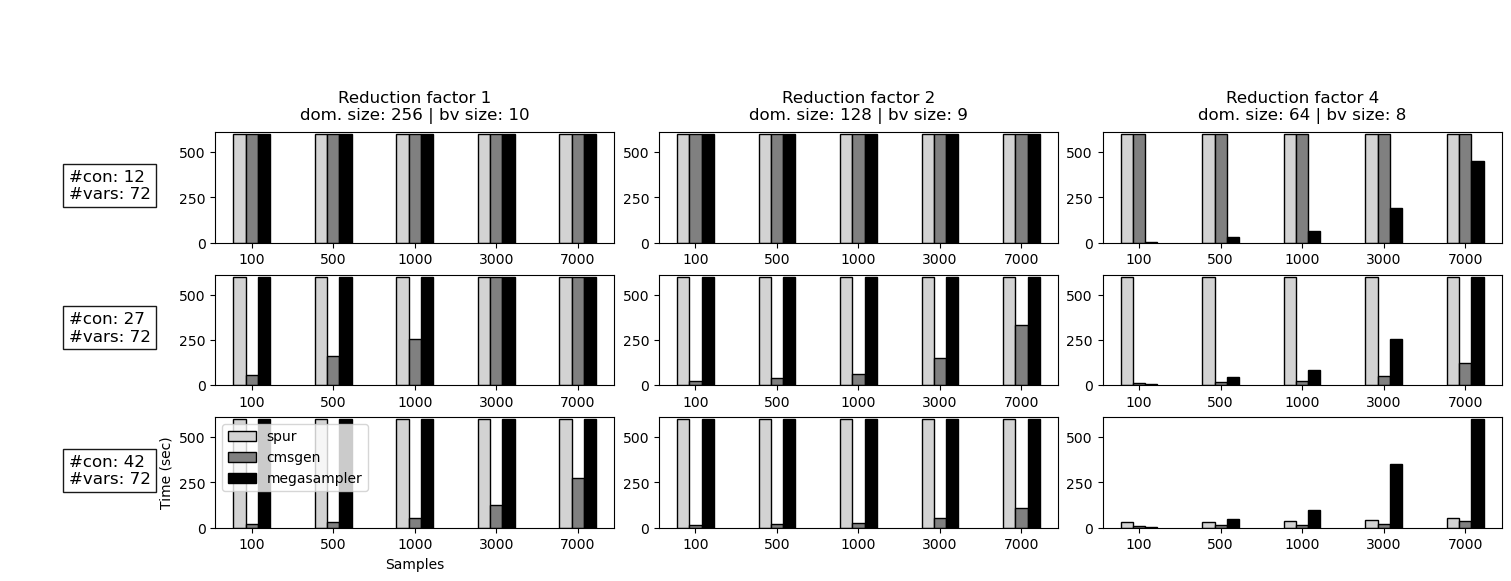

In [29]:
# plot all results
bounds = [12, 27, 42]
rfs = [1,2,4]

fig, axs = plt.subplots(len(bounds)+1,len(rfs)+1, figsize=(15,5.7), 
                        layout='constrained', width_ratios=np.concatenate([[1], np.repeat(4,len(rfs))]))

axs[0,0].set_axis_off()

for (c,i) in zip(bounds, range(len(bounds))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='books', num_con=c, 
                                                                        # the reduction factor is irrelevant
                                                                        rf=1)    
    axs[i+1,0].text(0.59,0.4,f'#con: {c}\n#vars: 72',
                    bbox=dict(facecolor='white', alpha=0.9),
                    fontsize=12)
    axs[i+1,0].axis('off')

for (r,j) in zip(rfs, range(len(rfs))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='books', rf=r, 
                                                                        # the number of constraints is irrelevant
                                                                        num_con=42) 
    axs[0,j+1].text(0.5, 0.0,f'Reduction factor {r}\ndom. size: {max_int_bv+1} | bv size: {num_bits}',
                    fontsize=12, horizontalalignment='center')
    axs[0,j+1].axis('off')

for (c,i) in zip(bounds, range(len(bounds))):
    for (r,j) in zip(rfs, range(len(rfs))):

        files = glob.glob(f'performance_results/books_results_case_{c}_rf_{r}_*.csv')
        if len(files) > 0:
            file  = files[0]
            df = pd.read_csv(file, index_col=False)
            x = df.samples.unique()
            ax = axs[i+1,j+1]

            num_samples_bars = df.samples.unique()
            means = {i: df[df.backend == i].total_time_mean for i in df.backend.unique()}

            x = np.arange(len(num_samples_bars))  # the label locations
            width = 0.15  # the width of the bars
            multiplier = 0                       

            colors = {'spur': '#D3D3D3', 'cmsgen': '#808080', 'megasampler': '#000000'}

            for attribute, measurement in means.items():
                offset = width * multiplier
                rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute], edgecolor='black')
                multiplier += 1

            ax.set_xticks(x + width, num_samples_bars)
            ax.set_ylim(0, 610)
            
            if i == len(bounds)-1 and j == 0:
                ax.set_ylabel('Time (sec)')
                ax.set_xlabel('Samples')
                ax.legend(loc='upper left', ncols=1)            
        else:
            axs[i+1,j+1].set_axis_off()
# plt.savefig('books_performance_results.pdf') ## save it if needed
plt.show();

#### Posterior plots and some diagnosis for CMSGen since it can handle the complete problem

Since CMSGen scales to the complete books problem, now we look into its trace plots; so that it can be compared with the results by Hazelton.

In [30]:
## Load saved trace with results
traces_books_cmsgen_original_problem = az.from_netcdf('traces/trace_books_cmsgen_samples_7000_original_problem.nc')

In [31]:
## Look at diagnostics first (same variable as var x8 in Hazelton's implementation)
## The ESS and MCSE look good
az.summary(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=['x58'])

arviz - WARNING - Shape validation failed: input_shape: (1, 7000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x58,181.484,7.71,170.0,194.0,0.091,0.065,7142.0,7060.0,NaN


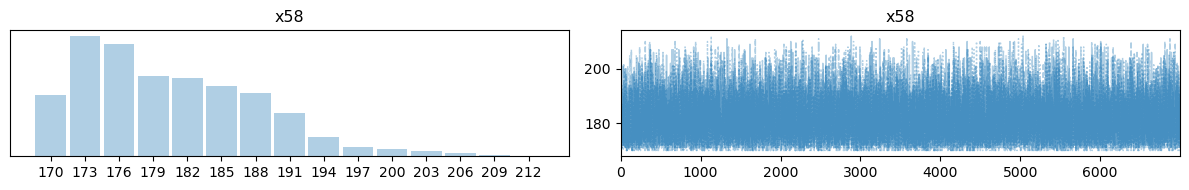

In [32]:
## Trace plot for var 58 
axs = az.plot_trace(traces_books_cmsgen_original_problem, combined=True, compact=True, var_names=['x58'], trace_kwargs={'color': 'black'})

#### Efficiency comparison with methods Hazelton's paper (DLB and FMB)

Here we perform a small comparison of the efficiency of sat-metropolis with CMSGen in the Books problem, as it can handle it. In other words, is sat-metropolis with CSMGen close to the performance of Hazelton's method?

First we check the quality of the samples we generated by looking into the mean ESS for all variables. This metric tells us how many of the samples we generated had actual information. The value is very close to 7000, which indicates very good quality samples.

In [33]:
az.ess(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=[f'x{i}' for i in range(72)]).to_array().mean().item()

6944.123912674674

Now we retrieve the average running time of sat-metropolis (CMSGen) for this case study

In [34]:
df_comp_haz = pd.read_csv('performance_results/books_results_case_42_rf_1_bits_10_max_int_255.csv')
running_time_cmsgen_books_7000 = df_comp_haz[(df_comp_haz.backend == 'cmsgen') & (df_comp_haz.samples == 7000)].total_time_mean.item()

The arrays below contain:
- `ess_hazelton`: ESS values for all variables and algorithms considered by Hazelton's 
- `hazelton_running_times`: Running time of three execution of each algorithm considered by Hazelton

We obtain the data by running Hazenton's code (https://github.com/MartinLHazelton/DynamicLatticeBasis/) for 200000 samples. We selected 200000 samples as this is the minimum value that achieves an ESS similar to sat-metropolis (CMSGen) for this problem.

In [35]:
# ESS values for all values and algorithms for one of the runs
ess_hazelton = np.array([
    [5673, 3478, 3478, 3645, 2911, 2764,   17,    22,    22,     0,     0],
    [5919, 3555, 3555, 3843, 2887, 2758,   17,    22,    22,     0,     0],
    [3126, 1471, 1471, 3083, 1785, 1681,    0,  8361,  8361,     0,     0],
    [5544, 2777, 2777, 4924, 2952, 2846,  521,   337,   337,    99,    95],
    [6868, 3029, 3029, 5314, 2973, 2832,  496,   309,   309,    94,   115],
    [5485, 1624, 1624, 4633, 2027, 1974,  789,   256,   256,   441,   181],
    [2516, 1433, 1433, 1918, 1358, 1343,  106,    56,    56,    98,    57],
    [2748, 1842, 1842, 2075, 1478, 1436,  239,   161,   161,    17,    16],
    [2229, 1786, 1786, 2049, 1417, 1374,  263,   166,   166,    11,    14],
    [4140, 2262, 2262, 3203, 2234, 2150,  375,   148,   148,   136,   101],
    [4119, 2478, 2478, 2894, 2152, 2063,  301,   168,   168,    32,    33],
    [2809, 1894, 1894, 2426, 1577, 1543,  369,   217,   217,    16,    18],
    [9940, 4596, 4596, 2389, 1523, 1462,  187,   148,   148,    44,    32],
    [6650, 3478, 3478, 2557, 1421, 1359,  187,   159,   159,    26,    33],
    [1768, 1068, 1068, 1939, 1383, 1323,    0,   345,   345,    59,    65],
    [9913, 3284, 3284, 2535, 1174, 1139,  245,   135,   135,    15,     9],
    [6408, 2578, 2578, 2740, 1384, 1339,  212,   135,   135,     8,     6],
    [2738, 1120, 1120, 2722, 1353, 1312,  342,   168,   168,    15,     8],
    [13106, 8688, 8688, 3146, 2445, 2332,  119,   502,   502,    57,    57],
    [3345, 2774, 2774, 2914, 2388, 2312,  275,   231,   231,    16,    21],
    [2119, 1816, 1816, 2444, 2171, 2110,  298,   229,   229,    15,    30],
    [10825, 3798, 3798, 2543, 1219, 1175,  212,   129,   129,    13,    10],
    [6246, 2841, 2841, 2784, 1539, 1491,  185,   139,   139,    12,     7],
    [2693, 1226, 1226, 2695, 1551, 1499,  321,   179,   179,    12,     8],
    [5885, 2578, 2578, 3384, 2020, 1945,   11,   630,   630,    76,    82],
    [10200, 5186, 5186, 3530, 2034, 1967,   11,    46,    46,    87,   107],
    [11934, 8247, 8247, 2784, 2010, 1957,    0,    42,    42,   142,   221],
    [4630, 1381, 1381, 2772, 1239, 1203,  460,   260,   260,    16,    35],
    [10760, 3795, 3795, 3097, 1492, 1439,  286,   187,   187,    18,    15],
    [11007, 5164, 5164, 2844, 1425, 1378,  322,   251,   251,    37,    10],
    [4294, 2045, 2045, 3276, 1584, 1525,  529,   850,   850,   118,   211],
    [12839, 8434, 8434, 3352, 2504, 2427,  209,   349,   349,    77,    75],
    [12993, 9468, 9468, 3113, 2435, 2370,  189,   346,   346,   101,    71],
    [4748, 1522, 1522, 2894, 1345, 1305,  439,   261,   261,    25,    36],
    [11069, 4282, 4282, 3256, 1687, 1626,  270,   183,   183,    22,    19],
    [11494, 5921, 5921, 3021, 1746, 1691,  291,   256,   256,    34,    11],
    [5981, 2394, 2394, 4107, 2282, 2202,    6,   684,   684,   113,   239],
    [5371, 2382, 2382, 4433, 2412, 2319,    6,   530,   530,   141,   236],
    [3246, 1764, 1764, 3655, 2049, 1965,    0,  1728,  1728,   318,   435],
    [5128, 1199, 1199, 3282, 1175, 1105,  435,   289,   289,    67,    67],
    [5621, 1660, 1660, 3859, 1592, 1508,  361,   236,   236,    70,    69],
    [4468, 1616, 1616, 3707, 1794, 1708,  439,   368,   368,    82,    77],
    [2661, 1569, 1569, 1944, 1397, 1353,  311,    77,    77,   160,   129],
    [1844, 1250, 1250, 1784, 1028, 1003,  217,   156,   156,    66,    45],
    [1508,  989,  989, 1566,  787,  758,  234,   162,   162,    48,    61],
    [4177, 1381, 1381, 2938, 1332, 1315,  401,   258,   258,    58,    46],
    [3447, 1517, 1517, 3064, 1324, 1259,  285,   155,   155,    46,    35],
    [2552, 1421, 1421, 2462, 1283, 1124,  324,   187,   187,    40,    37],
    [5168, 2549, 2549, 3214, 1998, 1928,  197,   101,   101,   132,   128],
    [4817, 2567, 2567, 3153, 2083, 2023,  197,    55,    55,   114,   113],
    [2225, 1638, 1638, 2581, 1855, 1778,    0,    25,    25,   229,   157],
    [3771, 1047, 1047, 2472, 1020,  935,  243,   127,   127,    38,    20],
    [3894, 1245, 1245, 2729, 1148, 1106,  192,   125,   125,    32,    19],
    [2568,  968,  968, 2604, 1305, 1274,  303,   139,   139,    44,    41],
    [3281, 2345, 2345, 3264, 2447, 2374,  676,   134,   134,   177,   131],
    [3076, 2323, 2323, 3113, 2200, 2150,  462,   269,   269,    91,    82],
    [2404, 1891, 1891, 2790, 2037, 1974,  456,   286,   286,    87,   145],
    [3861, 1186, 1186, 2593, 1201, 1056,  239,   107,   107,    28,    15],
    [4070, 1428, 1428, 2875, 1364, 1332,  193,   108,   108,    26,    12],
    [2666, 1148, 1148, 2668, 1431, 1398,  309,   146,   146,    52,    32],
    [5388, 2323, 2323, 2715, 1870, 1784,  290,   159,   159,   140,   138],
    [4135, 2250, 2250, 2890, 2152, 2068,  290,   164,   164,   146,   147],
    [1969, 1430, 1430, 2475, 1738, 1664,    0,   221,   221,   175,   233],
    [4596, 1315, 1315, 2893, 1218, 1207,  403,   193,   193,    57,    65],
    [4487, 1596, 1596, 3212, 1337, 1302,  254,   153,   153,    53,    49],
    [2965, 1226, 1226, 3004, 1328, 1295,  319,   203,   203,    66,    48],
    [5120, 2551, 2551, 3997, 1943, 1866,    0, 21265, 21265,   298,   130],
    [4691, 2622, 2622, 4278, 2979, 2887,    0,   112,   112,   173,   136],
    [3905, 2245, 2245, 4098, 2844, 2760,    0,   109,   109,   161,   154],
    [4816, 1478, 1478, 2935, 1206, 1182,  380,   183,   183,    40,    45],
    [4531, 1751, 1751, 3279, 1466, 1427,  257,   140,   140,    38,    37],
    [2978, 1404, 1404, 3089, 1584, 1555,  319,   190,   190,    66,    36]]).T

# 200000 samples (needed to obtain a similar ESS)
hazelton_running_times = np.array([
    [10.241, 3.264, 3.163,12.840, 6.052, 6.867,10.686, 7.006, 7.060, 4.481, 3.580],
    [9.590, 3.163, 3.169,12.774, 6.049, 5.981, 9.737, 6.632, 6.683, 4.172, 3.281],
    [9.757, 3.115, 3.322,13.600, 6.289, 6.136,10.250, 6.833, 6.529, 4.297, 3.421]
  ]).T

The table below shows that with 200000 samples only the first dynamic lattice basis algorithm achieves a similar performance than sat-metropolis (CMSGen).

Therefore, we compare the ratio between these two running times, and the outcome is that **sat-metropolis is 28x times slower than the best dynamic lattice basis algorithm for this problem**.

In [36]:
running_time_cmsgen_books_7000/hazelton_running_times.mean(axis=1)[0]

27.81839094017589

Hazelton's work also considers the average number high quality samples each algorithm generates per second. This is computed by computing the average ESS over all variables and divide it by running time.

In [37]:
ess_hazelton.mean(axis=1)/hazelton_running_times.mean(axis=1)

array([529.72770493, 806.02861035, 796.67754299, 232.12373132,
       287.8194671 , 268.63411294,  24.57508775,  93.47980069,
        94.39744475,  18.21428571,  21.87479738])

We do the same for sat-metropolis

In [38]:
(az.ess(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=[f'x{i}' for i in range(72)]).to_array().mean()/running_time_cmsgen_books_7000).item()

25.309939118148332

We observe that sat-metropolis generates 25 samples per second, which is slower than most of the algorithms considered by Hazelton. However, it it is better than full markov basis algorithms and comparable with Gibbs $\alpha=100$. 

Finally, we highlight that, thanks to the uniform sampling we use, the traces produced by sat-metropolis are much smaller in size. To obtain an average 7000 ESS we only need 7000 samples. However, for the same average ESS, it is required to sample at least 200000. In other words, **the best dynamic lattice basis method requires 28x times more samples than sat-metropolis to obtain a chain of similar quality (measured as ESS)**.

In [39]:
200000/7000

28.571428571428573

### Roads and Books summary table

In this section, we produce a pandas dataset that summarizes number of variables & constraints (original and bit-blasted), domain sizes and running times. We start by obtaining the information from the .cnf files produces by the Z3 bit-blasting function; which we access via the `save_dimacs` funciton in this library.

In [40]:
## Generate dimacs verion of Z3 problems to get number of clauses and variables after bitblasting
## We provide already the cnf files, so it is not needed to execute this cells
regenerate_cnf_files_for_books = False

if regenerate_cnf_files_for_books:
    cases = [12, 27, 42]
    rfs = [1,2,3,4]
    for (c, r) in [(c,r) for c in cases for r in rfs]:
    
        ### this data ignores for the cases (age,booktype) and (booktype,country)
        y_books = np.array([3, 12, 1, 21, 86, 16, 2, 24, 5, 184, 822, 163, # fix (country, age) count for all booktypes
                            40, 102, 13, 58, 253, 38, 18, 104, 40, 19, 147, 25, 52, 220, 35, # fix (age, booktype) count for all countries (ignores booktype F)
                            1, 3, 6, 8, 36, 5, 1, 14, 2, 1, 10, 13, 3, 43, 4] # fix (booktype, country) and count for all ages (ignores booktype F and USA)
                        )    
    
        ## Automatically calculated necessary bits
        num_bits = int(np.log2((y_books[:c]/r).max()))+1;
        max_int_bits = max([int(np.log2((total/summands)+1))+1 
                            for (summands,total) in zip(models.A_BOOKS[:c,:].sum(axis=1), (y_books[:c]/r))])
        max_int_bv = 2**max_int_bits-1
    
        (g, num_bits, num_vars) = models.get_books_sat(bound=c, y_reduction_factor=r, num_bits=num_bits, max_int_bv=max_int_bv)
        
        mcmc.sat.save_dimacs(g,f'cnf_files/books_cnf_case_{c}_rf_{r}.cnf')

In [41]:
## generate dimacs verion of Z3 problems to get number of clauses and variables after bitblasting
## We provide already the cnf files, so it is not needed to execute this cells
regenerate_cnf_files_for_roads = False

if regenerate_cnf_files_for_roads:
    num_cons = [2,3,4,5,6,7]
    rfs = [1,2,3,4]
    y = np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])
    for (c, r) in [(c,r) for c in num_cons for r in rfs]:
        samples = 10
        
        ## Automatically calculated necessary bits
        num_bits = int(np.log2((y[:c]/r).max()))+1;
        max_int_bits = max([int(np.log2((total/summands)+1))+1 
                            for (summands,total) in zip(models.__gen_conf_matrix(np.array([1,2,3,4,5,6,7][:c])).sum(axis=1), (y[:c]/r))])
        max_int_bv = 2**max_int_bits-1
     
        ## Get models
        (g, num_bits, num_vars) = models.get_roads_sat(num_bits = num_bits,
                                                       max_int_bv = max_int_bv,
                                                       num_con=c,
                                                       y_reduction_factor=r)
        
        mcmc.sat.save_dimacs(g,f'cnf_files/roads_cnf_con_{c}_rf_{r}.cnf')    

## Summary table

The code below produces the summary table.

In [42]:
def get_scalability_summary_table(symbols: bool = False):
    """
    Function to produces a summary table with #variables & #constraints, domain sizes and running times for 7000 samples for all backends.
    The function requires that the corresponding .csv files produced by the benchmarking sections for rodas and books above are generated.
    Furthermore, the function requires that the .cnf files containing the bit-blasted version of the models are generated using the functions in the previous two cells.
    """
    scalability_summary_data  = {
        'problem': [],
        '#vars': [],
        '#constraints': [],
        '#vars (bit-blasted)': [],
        '#clauses (bit-blasted)': [],
        'reduction': [],
        'bv size': [],
        'dom. size': [],
        'clause/var': [],
        'clause/var (bit-blasted)': [],
        'spur': [],
        'cmsgen': [],
        'megasampler': [],
    }

    __get_symbol = lambda x: '✔' if x else '✘'

    for file in glob.glob(f'performance_results/roads_results_*.csv')+glob.glob(f'performance_results/books_results_*.csv'):
        parsed_filename = file.split('_')
        problem    = parsed_filename[1].split('/')[1]
        num_con    = int(parsed_filename[4])
        red_fac    = int(parsed_filename[6])
        num_bits   = int(parsed_filename[8])
        max_int_bv = int(parsed_filename[11].split('.')[0])
        df = pd.read_csv(file)
        if red_fac < 5:
            scalability_summary_data['problem'].append(problem)
            scalability_summary_data['#vars'].append(__get_num_vars(problem, num_con))
            scalability_summary_data['#constraints'].append(num_con)
            scalability_summary_data['reduction'].append(red_fac)
            scalability_summary_data['bv size'].append(num_bits)
            scalability_summary_data['dom. size'].append(max_int_bv)
            scalability_summary_data['clause/var'].append(num_con/__get_num_vars(problem, num_con))

            spur_runtime   = df[(df.samples == 7000) & (df.backend == 'spur')].total_time_mean.values.item()
            scalability_summary_data['spur'].append(spur_runtime if not symbols else __get_symbol(spur_runtime < 600))
            cmsgen_runtime = df[(df.samples == 7000) & (df.backend == 'cmsgen')].total_time_mean.values.item()
            scalability_summary_data['cmsgen'].append(cmsgen_runtime if not symbols else __get_symbol(cmsgen_runtime < 600))
            megasampler_runtime = df[(df.samples == 7000) & (df.backend == 'megasampler')].total_time_mean.values.item()
            scalability_summary_data['megasampler'].append(megasampler_runtime if not symbols else __get_symbol(megasampler_runtime < 600))

            # not very elegant...
            filename = f'cnf_files/roads_cnf_con_{num_con}_rf_{red_fac}.cnf'
            if problem == 'books':
                filename = f'cnf_files/books_cnf_case_{num_con}_rf_{red_fac}.cnf'

            with open(filename, 'r') as file:
                first_line = file.readline()
                num_vars    = int(first_line[:-1].split(' ')[2])
                num_clauses = int(first_line[:-1].split(' ')[3])
                scalability_summary_data['#vars (bit-blasted)'].append(num_vars)
                scalability_summary_data['#clauses (bit-blasted)'].append(num_clauses)
                scalability_summary_data['clause/var (bit-blasted)'].append(num_clauses/num_vars)
                
                
    
    return pd.DataFrame(scalability_summary_data).sort_values(by=['#constraints','reduction'])


In [43]:
df_combined = get_scalability_summary_table(symbols=False)
# df_combined.to_latex('table.tex',float_format="{:.2f}".format, index=False) # save to latex if needed

In [44]:
df_combined

,problem,#vars,#constraints,#vars (bit-blasted),#clauses (bit-blasted),reduction,bv size,dom. size,clause/var,clause/var (bit-blasted),spur,cmsgen,megasampler
13,roads,13,2,203,713,1,11,1023,0.153846,3.512315,0.668340,0.968199,600.000000
19,roads,13,2,183,641,2,10,511,0.153846,3.502732,0.519811,0.725525,600.000000
7,roads,13,2,148,499,3,9,255,0.153846,3.371622,0.466384,0.699730,600.000000
3,roads,13,2,162,565,4,9,255,0.153846,3.487654,0.530197,0.730195,600.000000
5,roads,18,3,646,2722,1,11,1023,0.166667,4.213622,600.000000,76.112084,600.000000
12,roads,18,3,586,2464,2,10,511,0.166667,4.204778,249.428606,28.083052,600.000000
15,roads,18,3,512,2154,3,9,255,0.166667,4.207031,131.309515,25.218898,600.000000
18,roads,18,3,516,2168,4,9,127,0.166667,4.201550,15.919354,25.013111,600.000000
4,roads,22,4,1409,6491,1,11,511,0.181818,4.606813,600.000000,600.000000,600.000000
16,roads,22,4,1267,5827,2,10,255,0.181818,4.599053,600.000000,569.537571,600.000000


In [45]:
print(f'SPUR successful experiments: {df_combined['spur'].apply(lambda x: x<600).sum()} out of {df_combined['spur'].shape[0]}')
print(f'CMSGen successful experiments: {df_combined['cmsgen'].apply(lambda x: x<600).sum()} out of {df_combined['cmsgen'].shape[0]}')
print(f'MegaSampler successful experiments: {df_combined['megasampler'].apply(lambda x: x<600).sum()} out of {df_combined['megasampler'].shape[0]}')

SPUR successful experiments: 8 out of 35
CMSGen successful experiments: 18 out of 35
MegaSampler successful experiments: 7 out of 35


## Additional cases

### Haplotypes

The experiment below considers:
* 32 Haplotypes
* 5 placings in the haplotype ($2^5 = 32$)
* 100 genotypes

First, we generate a dataset of genotypes from a set of input
haplotype probabilities. The goal of the experiments is recovering
those probabilities after sampling.

In [46]:
# config of the experiment
bits_per_haplotype = 5
num_haplotypes = 2**bits_per_haplotype
num_genotypes = 100

# list of distinct haplotypes
haplotypes = list(map(list, itertools.product([0, 1], repeat=bits_per_haplotype)))

# list of haplotypes probabilities
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

# there must be a haplotype probability for each haplotype
if not (len(haplotypes) == len(haplotypesProb)):
    raise RuntimeError('The size of the list of haplotype probabilities does not match the list of distinct haplotypes')

# dict to store haplotype counts after sampling
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []} # NOTE: added by Raúl

# we generate `num_genotypes` by sampling pairs of haplotypes according to their probabilities
for i in range(num_genotypes):
    h1 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    h2 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2]))) # combines them to form a genotype
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); # NOTE: added by Raúl
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] + 1 # keeps count of sampled haplotypes 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] + 1 # keeps count of sampled haplotypes 
df = pd.DataFrame(data=d)

In [47]:
df

,h_1,h_2,g
0,"[1, 1, 0, 0, 1]","[1, 1, 1, 1, 1]","[2, 2, 1, 1, 2]"
1,"[0, 0, 0, 1, 1]","[1, 0, 1, 1, 0]","[1, 0, 1, 2, 1]"
2,"[0, 1, 1, 1, 0]","[1, 0, 1, 0, 1]","[1, 1, 2, 1, 1]"
3,"[1, 0, 1, 0, 1]","[1, 1, 1, 1, 1]","[2, 1, 2, 1, 2]"
4,"[0, 1, 0, 0, 1]","[0, 1, 0, 0, 0]","[0, 2, 0, 0, 1]"
...,...,...,...
95,"[1, 0, 0, 0, 0]","[0, 1, 1, 1, 0]","[1, 1, 1, 1, 0]"
96,"[0, 1, 0, 0, 0]","[1, 0, 0, 1, 0]","[1, 1, 0, 1, 0]"
97,"[1, 1, 0, 0, 0]","[1, 0, 1, 0, 1]","[2, 1, 1, 0, 1]"
98,"[0, 1, 0, 0, 0]","[1, 0, 0, 1, 0]","[1, 1, 0, 1, 0]"


In [48]:
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_haplotypes_sat(
    genotypes=np.array(genotypes)
)
(s, num_vars) = models.get_haplotypes_smt(
    genotypes=np.array(genotypes)
)
backends = ['spur', 'cmsgen', 'megasampler']
traces_haplotypes = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            reweight_samples=True,
            timeout_sampler=TIMEOUT,
            num_samples=1000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4618/4618/0
independent support size:  	0
clauses (all/long/binary/unit): 10346/4472/4504/1370
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	567 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	567 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	4618/4618/0
clauses (removed) 		10346 (0)
decisions 				248
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1370
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache siz

In [51]:
def __get_distinct_haplotype_counts(trace, 
                                    var_names: list[str], 
                                    bits_per_haplotype: int):
    """
    Returns the count of each distinct sampled haplotype for the Bitvector specified by the variables in `var_names`
    Note: Try to reimplement this function more efficiently. The bottleneck seem to be the casting of integer lists to str
    """
    return np.unique(np.array([str(a).replace(" ", ", ") for a in trace.posterior[var_names].to_array().values.reshape(bits_per_haplotype,-1).T]), return_counts=True)

def get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype):
    """
    Returns a dictionary where keys are haplotypes and values are the counts of each haplotype in the trace.
    Note: It is computationally expensive due to the function `__get_distinct_haplotype_counts`.
    """
    # list of lists where each list contains the variables for each BitVector (to be used as indexes in the posterior trace)
    haplo_var_vectors = [[f'x{i+j}' for j in range(bits_per_haplotype) ] for i in np.arange(0,num_vars,step=bits_per_haplotype)]
    # list of pairs where the first element in each pair is list with
    # each distinct haplotype, and the second pair element is a list
    # with the counts of the corresponding haplotype
    counts_per_var_vector = [__get_distinct_haplotype_counts(trace, haplo_var_vector, bits_per_haplotype) for haplo_var_vector in haplo_var_vectors]
    # initilize a dict with distinct haplotypes as keys and values are counts of each haplotype (initially 0)
    haplotypesnumber_posterior = { str(haplotypes[i]): 0 for i in range(2**bits_per_haplotype) }
    # iterate over all haplotype counts for each BitVector, and add them to the dictionary above
    for i in counts_per_var_vector:
        num_distinct_haplotypes = len(i[0])
        for j in range(num_distinct_haplotypes):
            haplotypesnumber_posterior[i[0][j]] += i[1][j]
    # return dictionary with all counts
    return haplotypesnumber_posterior

def normalize_haplotypes_posterior(haplo_numbers):
    """
    Takes as input a dict with haplotypes as keys and their counts and values.
    Returns a similar dict where values is the probability of each haplotype (frequentist)
    """
    total = sum([haplo_numbers[x] for x in list(haplo_numbers.keys())])
    return { x: haplo_numbers[x]/total  for x in list(haplo_numbers.keys())}

get_values = lambda x: [x[k] for k in x.keys()]

In [52]:
# time consuming
haplotypesnumber_posteriors = \
    [get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype)
     for trace in traces_haplotypes]

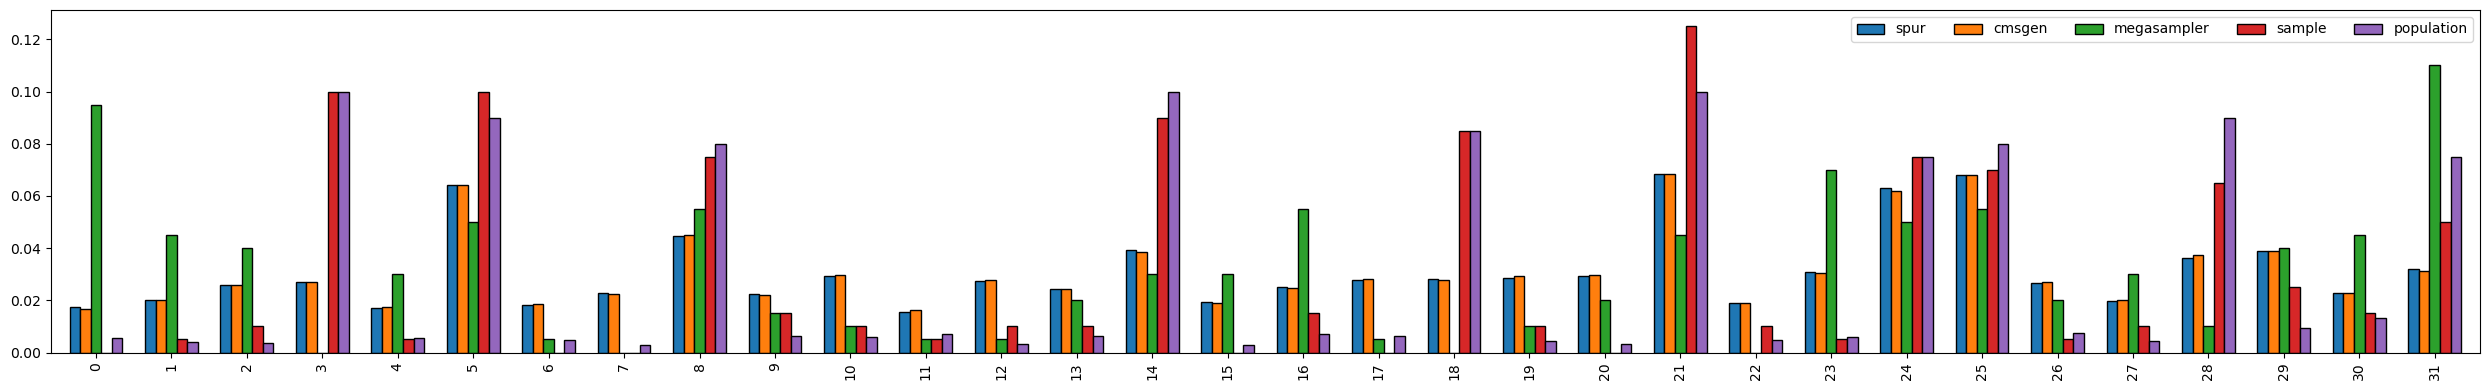

In [65]:
# zipping posterior counts with their corresponding backend
sources = [(b,p) for b,p in zip(backends,haplotypesnumber_posteriors)]
# adding counts from the sample
sources.append(('sample',haplotypesnumber))
# normalizing counts to compute haplotypes frequencies (in a frequentist manner)
normalized_sources = [(b,get_values(normalize_haplotypes_posterior(d))) for (b,d) in sources]
# adding the ground truth (haplotype frequencies used to generate genotypes)
normalized_sources.append(('population', haplotypesProb))
# put all together in a dataframe
df_p = pd.DataFrame(data=dict(normalized_sources))
# plot it!
ax = df_p.plot.bar(figsize=(25,4), edgecolor='black', width=.7)
ax.legend(ncols=5);